#Assignment 6: Q-Learning
##Task 1. Gridworld
Laura Quiroga - 201922965

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

#Definición del ambiente

In [2]:
class Environment:
  def __init__(self, states=[], rewards=[]):
    self.board = states
    self.rewards = np.zeros_like(self.board, dtype=float)
    self.init_state = (0,0)

    for x in range(len(states)):
      for y in range(len(states[0])):
        if states[x][y]=='s':
          self.init_state = (x,y)

    for r in rewards:
      sx=r[0][0]-1
      sy=r[0][1]-1
      self.rewards[sx][sy]=r[1]


  def start(self):
    """
    Devuelve casilla de entrada
    """
    return self.init_state
  
  def dim(self): 
    """
    Devuelve tamanio del tablero
    """
    return [len(self.board), len(self.board[0])]

#Definición del agente

In [3]:
class Agent:
    def __init__(self, init_state):
      self.state = init_state
      self.actions = ['up', 'right', 'down', 'left']
      
    def reset(self, init_state):
      """
      Lleva al agente a la posición inicial
      """
      self.state = init_state

    def  set_state(self, next_state):
      """
      Actualiza el estado actual del agente
      """
      self.state = next_state
  

#Definición de la clase intermediaria

In [4]:
#Clase que media la interacción entre el agente y su entorno
#Así nos aseguramos de que el agente no conozca lo que no debe conocer de su entorno

class Learner:
    def __init__(self, agent, env, alpha=0.5, gamma=0.6, epsilon=0.1):
      #hyper parameters
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon = epsilon
      self.env = env
      self.agent = agent          #actual agent
      self.qtable = self.__initdic__() #rewards table
      #initiate random policy
      self.policy = [[np.random.randint(len(self.agent.actions)) for y in range(self.env.dim()[1])] for x in range(self.env.dim()[0])]
    
    def __initdic__(self):
      """
      Inicializa la q-tabla en 0s 
      Dim: x,y,actions
      """
      table = np.zeros((self.env.dim()[0], self.env.dim()[1], len(self.agent.actions)), dtype=object)
      return table


    def run(self):
      print(self.policy)
      done = False
      while not done:
          current_state = self.agent.state

          # Con prob epsilon: toma acción aleatoria
          if random.uniform(0,1) < self.epsilon:
              action = self.randomAction()
          # Con prob 1-epsilon: toma mejor acción según q-tabla
          else:
              action = self.choose_best_action(current_state)

          next_state, reward, done, info = self.step(action)
          old_value = self.qtable[current_state[0],current_state[1]][action]

          next_max = np.max(self.qtable[next_state[0], next_state[1]])

          #compute q_value(s, a, t): (1-alpha) *q_value(s, a, t-1)+ apha*(r + gamma * max_q_value(s', t))
          new_value = (1 - self.alpha)*old_value + self.alpha*(reward + self.gamma*next_max)
          self.qtable[current_state[0],current_state[1]][action] = new_value

          #print(info) #formated result
          #print(f'{current_state}, {action}, {next_state}')
      new_policy = self.calculate_policy()
      converged = self.check_convergence(new_policy)
      self.policy = new_policy
    
      return converged

    
    def calculate_policy(self):
      """
      Calcula la política para cada estado
      """
      policy = np.zeros((self.env.dim()[0], self.env.dim()[1]), dtype=object)
      for x in range(self.env.dim()[0]):
        for y in range(self.env.dim()[1]):
          policy[x][y]=self.choose_best_action((x,y))
      return policy

    def check_convergence(self, new_policy)->bool:
      converged = True
      for x in range(self.env.dim()[0]):
        for y in range(self.env.dim()[1]):
          if self.policy[x][y]!=new_policy[x][y]:
            return False
      return converged

    def randomAction(self):
      return random.randint(0,len(self.agent.actions)-1)
    
    def choose_best_action(self, current_state):
      """
      Escoge la mejor acción según los valores de la q_tabla
      Si hay empate, escoge aleatoriamente entre las acciones óptimas
      """
      q_values = self.qtable[current_state[0], current_state[1]]
      max_q_value = -math.inf
      best_actions = []
      for i in range(len(q_values)):
        if q_values[i]>max_q_value:
          max_q_value = q_values[i]
          best_actions.clear()
          best_actions.append(i)
        elif q_values[i]==max_q_value:
          best_actions.append(i)
      if self.policy[current_state[0]][current_state[1]] in best_actions:
        return self.policy[current_state[0]][current_state[1]]
      return np.random.choice(best_actions)

    def step(self, i_action):
      """
      Ejecuta la acción dada a partir del estado actual del agente
      """
      old_state = self.agent.state
      action = self.agent.actions[i_action]
      next_state, reward, done = self.takeAction(old_state, action)

      info = f'Executed action: {action}. From {old_state} to {next_state}. Reward: {reward} Terminal: {done}'
      return next_state, reward, done, info

    def takeAction(self, state, action):
      max_x = self.env.dim()[0]-1
      max_y = self.env.dim()[1]-1
      done = False

      if action == "up":
        next_state = (state[0], max(state[1]-1, 0))
      elif action == "down":
        next_state = (state[0], min(state[1]+1, max_y))
      elif action == "left":
        next_state = (max(state[0]-1,0), state[1])
      else:
        next_state = (min(state[0]+1, max_x), state[1])

      #si la casilla nueva no es pisable ->next_state=state
      if self.env.board[next_state[0]][next_state[1]]=='o':
        next_state=state

      self.agent.set_state(next_state)

      if self.env.board[next_state[0]][next_state[1]]=='g':
        done = True

      reward = self.env.rewards[next_state[0]][next_state[1]]

      return next_state, reward, done

#Visualización de resulatados

In [5]:
def find_max (value_list):
  max_value = -math.inf
  best_index = []
  for i in range(len(value_list)):
    if value_list[i]>max_value:
      max_value = value_list[i]
      best_index.clear()
      best_index.append(i)
    elif value_list[i]==max_value:
      best_index.append(i)
  return np.random.choice(best_index)

In [6]:
def print_table(results):
  print("Q-table\n")
  dimensions = results[1].dim()
  d = dict()
  for x in range(dimensions[0]):
    for y in range(dimensions[1]):
      q_values = [x for x in results[0][x][y]]
      d.update({f'{x+1,y+1}': q_values})
  print ("{:<8} {:<15} {:<15} {:<15} {:<15}".format('State',f'{results[2].actions[0]}',f'{results[2].actions[1]}',
                                             f'{results[2].actions[2]}',f'{results[2].actions[3]}'))
  for k, v in d.items():
    a1, a2, a3, a4 = v
    print ("{:<8} {:<15} {:<15} {:<15} {:<15}".format(k, value_to_str(a1), value_to_str(a2), value_to_str(a3), value_to_str(a4)))

def value_to_str(value)-> str:
  if not value is None:
    return round(value, 6)
  return "None"

def show_results(results):
  n_episodes = results[3]
  #results = (q_tabla, environment, agent)
  dimensions = results[1].dim()
  grid_x=list(range(1,dimensions[0]+1))
  grid_y=list(range(1,dimensions[1]+1))
  fig, ax = plt.subplots()
  
  values = np.zeros((dimensions[1],dimensions[0]))
  actions = np.zeros((dimensions[1],dimensions[0]), dtype=object)

  for x in range(dimensions[0]):
    for y in range(dimensions[1]):
      if results[1].board[x][y] != "o":
        max_q_value = find_max(results[0][x][y])
        if results[1].board[x][y] == "g":
          values[y][x]= None
          actions[y][x] = "Exit"
        else:
          values[y][x]= round(results[0][x][y][max_q_value],4)
          actions[y][x] = (results[2].actions[max_q_value])

      else:
        values[y][x]=None
        actions[y][x]=None

  im = ax.imshow(values)
  ax.set_xticks(np.arange(len(grid_x)), labels=grid_x)
  ax.set_yticks(np.arange(len(grid_y)), labels=grid_y)
  ax.set_title(f"Policy results after evaluation of {n_episodes} episodes")

  # Loop over data dimensions and create text annotations.
  for i in range(len(grid_y)):
      for j in range(len(grid_x)):
        text = ax.text(j, i, f"{str(values[i,j])}\n{actions[i,j]}",
                      ha="center", va="center", color="k")
  plt.clf

  #

  plt.rcParams['figure.figsize'] = [8, 8]
  plt.show()
  plt.clf

  print_table(results)
      


#Ejecución de escenarios de prueba

In [7]:
def test(states, rewards):

    e = Environment(states, rewards)
    a = Agent(e.init_state)
    l = Learner(a, e)

    episodes = 0
    convergence_count = 0
    while convergence_count<30:
        print(f"Episode: {episodes+1}")
        converged = l.run()
        if converged:
          convergence_count+=1
        else:
          convergence_count=0
        a.reset(e.init_state)
        episodes+=1
    return (l.qtable, e, a, episodes)

In [8]:
#Ejecutar el escenario de prueba 1
states_small_gridworld = [['e','e','s'],['e','o','e'],['e','e','e'],['g','g','e']]
rewards_small_gridworld = [((4,1),1), ((4,2),-1)]
results1 = test(states_small_gridworld,rewards_small_gridworld) 

Episode: 1
[[2, 1, 1], [1, 2, 3], [0, 1, 2], [0, 1, 3]]
Episode: 2
[[2 1 1]
 [1 2 3]
 [0 2 2]
 [0 1 3]]
Episode: 3
[[2 1 1]
 [1 2 3]
 [1 2 2]
 [0 1 3]]
Episode: 4
[[2 1 1]
 [1 2 3]
 [1 2 2]
 [0 1 3]]
Episode: 5
[[2 1 1]
 [1 2 3]
 [1 2 2]
 [0 1 3]]
Episode: 6
[[2 1 1]
 [1 2 3]
 [1 0 2]
 [0 1 3]]
Episode: 7
[[2 1 1]
 [1 2 3]
 [1 0 2]
 [0 1 3]]
Episode: 8
[[2 1 1]
 [1 2 3]
 [1 0 2]
 [0 1 3]]
Episode: 9
[[2 1 1]
 [1 2 3]
 [1 0 0]
 [0 1 3]]
Episode: 10
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 11
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 12
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 13
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 14
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 15
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 16
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 17
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 18
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 19
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 20
[[2 1 1]
 [1 2 1]
 [1 0 0]
 [0 1 3]]
Episode: 21
[[2 1 1]


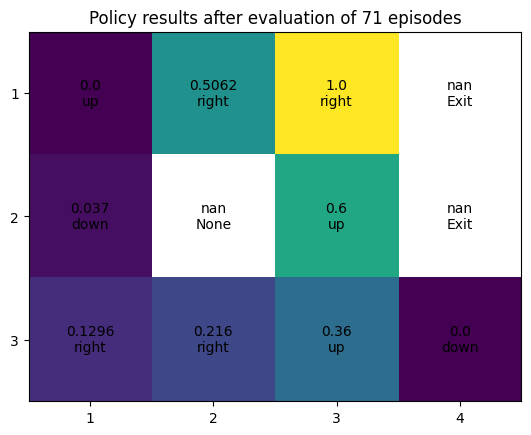

Q-table

State    up              right           down            left           
(1, 1)   0               0.0             0.0             0.0            
(1, 2)   0.0             0.0             0.037001        0.0            
(1, 3)   0.0             0.1296          0.0             0.075211       
(2, 1)   0               0.50625         0               0              
(2, 2)   0               0               0               0              
(2, 3)   0.102136        0.216           0.0648          0.03888        
(3, 1)   0.45            1.0             0.315           0.1575         
(3, 2)   0.6             -0.875          0.162           0.18           
(3, 3)   0.36            0.0             0.108           0.097183       
(4, 1)   0               0               0               0              
(4, 2)   0               0               0               0              
(4, 3)   -0.75           0               0               0.0            


In [9]:
show_results(results1)

In [10]:
#Ejecutar el escenario de prueba 2
states_gridworld = [['s','e','e','e','e','e','e','e','e','e'],
          ['e','e','o','e','e','e','e','e','e','e'],
          ['e','e','o','e','e','e','e','e','e','e'],
          ['e','e','o','e','e','e','e','e','e','e'],
          ['e','e','o','o','o','o','o','o','e','e'],
          ['e','e','e','e','e','g','e','e','e','e'],
          ['e','e','o','e','e','e','e','e','e','e'],
          ['e','e','o','e','e','e','e','e','e','e'],
          ['e','e','o','e','e','e','e','e','e','e'],
          ['e','e','e','e','e','e','e','e','e','e'],]
rewards_gridworld = [((6,5),-1),((6,6),1),((6,8),-1), ((7,8),-1)]
results2 = test(states_gridworld,rewards_gridworld) 

Episode: 1
[[1, 1, 2, 1, 0, 1, 2, 0, 2, 0], [1, 3, 1, 0, 2, 1, 2, 1, 2, 2], [1, 2, 3, 2, 1, 2, 2, 2, 3, 1], [0, 3, 1, 2, 2, 3, 1, 3, 3, 3], [3, 1, 2, 0, 2, 2, 3, 2, 3, 3], [3, 0, 3, 3, 0, 0, 3, 0, 3, 1], [1, 0, 2, 1, 0, 0, 3, 2, 1, 1], [1, 0, 3, 3, 3, 0, 2, 2, 3, 3], [1, 1, 2, 1, 0, 3, 0, 2, 1, 2], [2, 1, 2, 3, 1, 2, 1, 2, 0, 1]]
Episode: 2
[[1 1 2 1 0 1 2 0 2 0]
 [1 3 1 0 2 1 2 1 2 2]
 [1 2 3 2 1 2 2 2 3 1]
 [0 3 1 2 2 3 1 3 3 3]
 [3 1 2 0 2 2 3 2 3 3]
 [3 0 3 3 0 0 0 0 3 1]
 [1 0 2 1 0 0 3 2 1 1]
 [1 0 3 3 3 0 2 2 3 3]
 [1 1 2 1 0 3 0 2 1 2]
 [2 1 2 3 1 2 1 2 0 1]]
Episode: 3
[[1 1 2 1 0 1 2 0 2 0]
 [1 3 1 0 2 1 2 1 2 2]
 [1 2 3 2 1 2 2 2 3 1]
 [0 3 1 2 2 3 1 3 3 3]
 [3 1 2 0 2 2 3 2 3 3]
 [3 0 3 3 2 0 0 0 3 1]
 [1 0 2 1 0 0 3 2 1 1]
 [1 0 3 3 3 0 2 2 3 3]
 [1 1 2 1 0 3 0 2 1 2]
 [2 1 2 3 1 2 1 2 0 1]]
Episode: 4
[[1 1 2 1 0 1 2 0 2 0]
 [1 3 1 0 2 1 2 1 2 2]
 [1 2 3 2 1 2 2 2 3 1]
 [0 3 1 2 2 3 1 3 3 3]
 [3 1 2 0 2 2 3 2 3 3]
 [3 0 3 3 2 0 0 0 3 1]
 [1 0 2 1 0 0 3 2 1 1]
 [1 0 3 3 3 

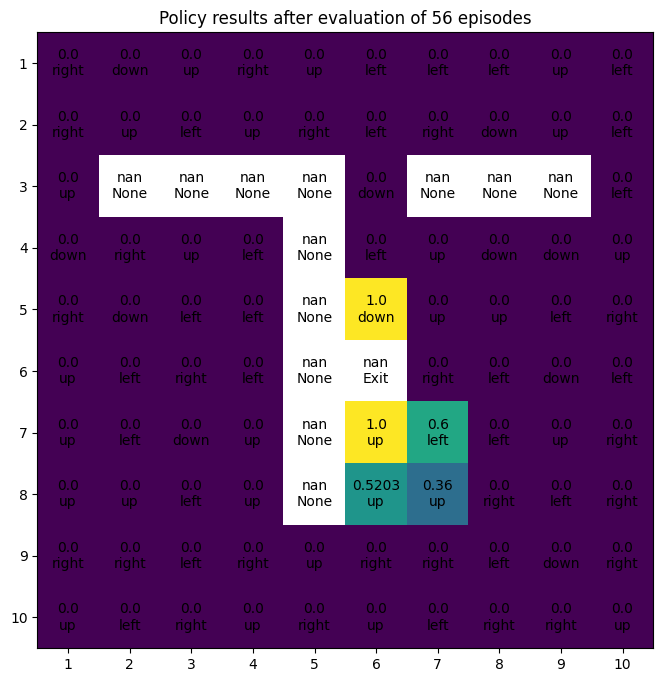

Q-table

State    up              right           down            left           
(1, 1)   0.0             0.0             0.0             0.0            
(1, 2)   0.0             0.0             0.0             0.0            
(1, 3)   0.0             0.0             0.0             0.0            
(1, 4)   0.0             0.0             0.0             0.0            
(1, 5)   0.0             0.0             0.0             0              
(1, 6)   0.0             0.0             0.0             0.0            
(1, 7)   0.0             0.0             0.0             0.0            
(1, 8)   0.0             0.0             0.0             0.0            
(1, 9)   0.0             0.0             0.0             0.0            
(1, 10)  0.0             0.0             0.0             0.0            
(2, 1)   0.0             0.0             0.0             0.0            
(2, 2)   0.0             0.0             0.0             0.0            
(2, 3)   0               0               0

In [11]:
show_results(results2)